## Project Description

The supermarket chain Good Seed like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. To conduct that evaluation, let us assume we have the following:

- The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol
- Computer vision methods can be used to determine age of a person from a photo
- we are given set of photographs of people with their ages indicated

Thus our task is to build and evaluate a model for verifying people's age given their photo.


## Initialization

First import all the libraries needed for the project

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there we can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Let us store the path for the datasets in a variable file_path for easy reference.

In [9]:
file_path = '/datasets/faces/'

Given the fact that the number of image files is rather high, it is better to avoid reading them all at once, which would greatly consume computational resources. So, let us build a generator with the ImageDataGenerator generator which loads the images in batches. 

The label file can be loaded as pandas dataframe from the labels.csv file.

Below are the functions load_data for loading face images and load_labels for loading labels file.

In [10]:
def load_data(path):
    
    """
    It loads the labels from csv as target and the image files in the 'final_files' folder in the path as features and 
    returns the DirectoryIterator containing tuple of features numpy array and target numpy array in batches.
    
    """
    
    datagen = ImageDataGenerator(
        rescale=1.0/255.0)
   
    labels = load_labels(path + "labels.csv")
   

    gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 
    return gen_flow

def load_labels(filename):
    """
        loads the labels from the csv file with filename
    """
    
    return pd.read_csv(filename)


Now let us first load the labels file

In [11]:
input_data = load_labels(file_path + "labels.csv")
display(input_data)
display(input_data.info())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

Thus the labels file has 7591 records meaning we have pictures and ages of 7591 persons. Next, we will load the images along with their ages in numpy arrays using function `load_data` which saves the memory by loading them in batches.

In [12]:
itr = load_data(file_path)

Found 7591 validated image filenames.


<div class="alert alert-block alert-success">
<b>Success:</b> Great that you've remembered about initial analysis of the uploaded file.
</div>

Next, we will retrieve the first batch of the training ready data and do the exploratory data analysis

In [13]:
# load the first batch
features, target = next(itr)

In [14]:
print("First batch features dimensions", features.shape)
print("First batch target dimensions", target.shape)

First batch features dimensions (32, 224, 224, 3)
First batch target dimensions (32,)


### Findings

- We have 7591 persons images and their ages that are to be used for training our neural network
- Images occupies lot of memory, so we are loading them in batches using ImageDataGenerator
- With batch size of 32 we have 32 images with 224 * 224 pixels having 3 color channels as input for our neural network and their corresponding ages as target variables for first batch.

## Exploratory Data Analysis


Now let us see how the ages are distributed. Let us examine the first batch of data we loaded usind ImageDataGenerator.

Text(0.5, 1.0, 'Age distribution in first batch of training data')

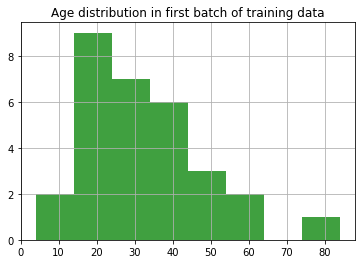

In [15]:
plt.hist(target, bins=np.arange(min(target), max(target), 10),  facecolor='g', alpha=0.75);
plt.grid(True)
plt.title("Age distribution in first batch of training data")

Text(0.5, 1.0, 'Age distribution in the entire training dataset')

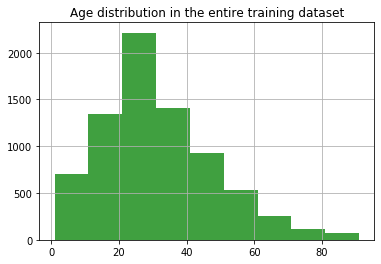

In [16]:
plt.hist(input_data.real_age, bins=np.arange(min(input_data.real_age), max(input_data.real_age), 10),  facecolor='g', alpha=0.75);
plt.grid(True)
plt.title("Age distribution in the entire training dataset")


<div class="alert alert-block alert-info">
<b>Improve: </b> It would be better if you've increased number of bins.
</div>

Both the histograms are right skewed. The peak occurs within 10-30 ages for the first batch sample, which is very close to the peak of the entire dataset, which is between 20-30. Thus, the samples in first batch represents the overall population very well. 

In both histograms we can observe that there is high number of people with ages 40 or less. The dataset has very few people with ages above 60.

Now let us have a look at the images of 15 people in our batch training data.

<Figure size 1600x480 with 0 Axes>

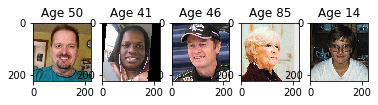

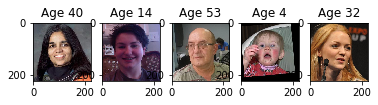

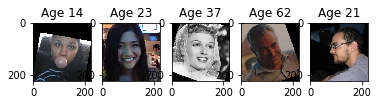

In [17]:
%matplotlib inline
plt.figure(figsize = (20, 6), dpi = 80)
for i in range(0, 15, 5):
    fig, ax = plt.subplots(1, 5)
    for j in range(5):
        ax[j].imshow(features[i+j], cmap='gray');
        ax[j].set_title("Age {}".format(target[i+j]));

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see that ages were inserted in the titles.
</div>

The images shows people of different ages. First glimpse on the images displayed shows that there are no artifacts in their corresponding ages. Some images have only partial view of the faces. Different backgrounds in the images. Some images have less clarity while most images are very clear. Some images appear tilted to right or left.

### Findings

- The age distribution of the population and the first batch sample are right skewed
- The dataset has more younger population of ages 40 or below
- The images has mix of people of different ages, races taken in different angles.

<div class="alert alert-block alert-success">
<b>Success:</b> Analysis was done well!
</div>

## Modelling

Now let us build and train a convolutional neural network on the GPU platform, using the dataset with photos of people to predict the age. 

Since we are tasked to predict the age which usually a integer number, this can not be classification problem. We should use regression. We will use the ResNet50 network which was pre-trained by using the ImageNet dataset. It has 1000 classes, so there are 1000 neurons in the output layer. These 1000 neurons have to be reduced to only one neuron at the output layer which predicts the age. 

Since we need to predict a number instead of class, we will use 'ReLU' as the activation instead of sigmoid or softmax. We will Adam algorithm for optimization with learning rate of 1e4. As this is a regression problem, we will use mean squared error for calculating loss amd Mean absolute error as the evaluation metric. We need to get the MAE score for the test set no higher than 8.

First let us define essential functions for loading training and test dataset, creating the Resnet50 model and training it as explained below. 

- load_train(path)
    - it loads the train dataset
- load_test(path)
    - it loads the test dataset
- create_model(input_shape)
    - it defines a model
- train_model(model, train_data, test_data, batch_size, epochs, steps_per_epoch, validation_steps)
    - it controls the training of the model

In [18]:
def load_train(path):
    """
    It loads the validation/test part of dataset from path
    """
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0, validation_split=0.25)
   
    labels = load_labels(path + "labels.csv")
   

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345) 
    return train_gen_flow

def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    test_datagen = ImageDataGenerator(
        rescale=1.0/255.0, validation_split=0.25)
   
    labels = load_labels(path + "labels.csv")
   

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_gen_flow


<div class="alert alert-block alert-danger">
<b>Needs fixing:</b> Different functions should be used for loading train and test data. 
    
In `ImageDataGenerator` for train and test `validation_split=0.25` parameter should be used. 
    
In`flow_from_dataframe` `subset='training'` or `subset='validation'` parameters shoudl be used. Otherwise learning validation would be made on the same set.
    
</div>

<span style="background-color: aqua">
<span style="color:green">
<b>Student comments: </b> load_train and load_test functions are updated accordingly. Thanks for your feedback
    </span>   
</span>

In [19]:
def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
    input_shape=input_shape, weights='imagenet', include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(120, activation='relu')) 
    model.add(Dense(60, activation='relu')) 
    model.add(Dense(12, activation='relu')) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.00001)

    model.compile(
    	optimizer=optimizer,
    	 loss='mean_squared_error',
    	metrics=['mae'])
    return model



In [20]:
def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=15,
    steps_per_epoch=None,
    validation_steps=None,
):


    if steps_per_epoch is None:
    	steps_per_epoch = len(train_data)
    if validation_steps is None:
    	validation_steps = len(test_data) 
    model.fit(train_data,
          validation_data=test_data,
          batch_size=batch_size,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
         validation_steps=validation_steps,
        verbose=2) 
   

    return model 

Next, we will build a single script containing all of the above functions along with the initalization section. That script can easily be executed in GPU platform after uploading it.

### Prepare the Script to Run on the GPU Platform

Now the defined the necessary functions which can be composed into a script with the below code. We can download this script via the "File|Open..." menu, and then upload it later for running on the GPU platform.

In [21]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model, load_labels]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

The 'run_model_on_gpu.py' file is downloaded and uploaded in the GPU platform and the model is updated to get optimized MAE values.

### Output

The output from the GPU platform is shown below - The test MAE is 7.27 which is well below our threshold MAE of 8

```
Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-01-08 19:53:29.371054: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-08 19:53:29.667308: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 45s - loss: 1012.0427 - mae: 27.4864 - val_loss: 1137.8382 - val_mae: 29.2697
Epoch 2/15
178/178 - 37s - loss: 294.6151 - mae: 13.5937 - val_loss: 1125.2434 - val_mae: 29.0563
Epoch 3/15
178/178 - 37s - loss: 77.2641 - mae: 6.6024 - val_loss: 798.0519 - val_mae: 23.2451
Epoch 4/15
178/178 - 37s - loss: 34.5475 - mae: 4.5249 - val_loss: 195.8135 - val_mae: 10.6966
Epoch 5/15
178/178 - 36s - loss: 19.9628 - mae: 3.5054 - val_loss: 132.3287 - val_mae: 8.9080
Epoch 6/15
178/178 - 37s - loss: 14.2603 - mae: 2.9733 - val_loss: 88.1112 - val_mae: 7.1328
Epoch 7/15
178/178 - 37s - loss: 12.2058 - mae: 2.7202 - val_loss: 84.9063 - val_mae: 7.0056
Epoch 8/15
178/178 - 37s - loss: 11.4873 - mae: 2.6583 - val_loss: 87.4468 - val_mae: 7.0497
Epoch 9/15
178/178 - 37s - loss: 11.0292 - mae: 2.5682 - val_loss: 87.9820 - val_mae: 7.0639
Epoch 10/15
178/178 - 37s - loss: 10.7904 - mae: 2.5425 - val_loss: 86.0165 - val_mae: 6.9957
Epoch 11/15
178/178 - 37s - loss: 10.1799 - mae: 2.4733 - val_loss: 85.6244 - val_mae: 6.9637
Epoch 12/15
178/178 - 37s - loss: 9.3428 - mae: 2.3896 - val_loss: 87.8532 - val_mae: 7.0637
Epoch 13/15
178/178 - 37s - loss: 9.1336 - mae: 2.3422 - val_loss: 87.7574 - val_mae: 7.1409
Epoch 14/15
178/178 - 37s - loss: 8.6206 - mae: 2.3038 - val_loss: 84.4649 - val_mae: 6.9986
Epoch 15/15
178/178 - 37s - loss: 8.3885 - mae: 2.2464 - val_loss: 93.9595 - val_mae: 7.2748
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 93.9595 - mae: 7.2748
Test MAE: 7.2748
```

#### Findings
- First epoch had MAE 27 which then gradually reduced to 2.24 in the final training epoch.
- The MAE is 7.27 which lower than the threshold of 8
- The convolutional network model we built is very efficient with lowest MAE.

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Absolutely right now!
</div>

## Conclusions

In this project we are given the task is to build and evaluate a model for verifying people's age based on their photo. The model should predict in such a way that Mean absolute error for model should not exceed 8. To build such a Convolutional network model we did the following

- loaded the given dataset of 7591 persons pictures with their ages efficiently into memory as batches using ImageDataGenerator

- visualized age distribution of a sample batch and the overall dataset and found that there are fewer persons with ages above 60 in the dataset

- found that the data has high number of persons with ages 40 or below 

- we printed few images and analysed them - the pictures are a good mix of different ages, race, angles including pictures with partial view of the faces

- To build model we determined this is regression problem and output layer needs to be only one neuron. 

- Given the regression model, we determined the loss function as MSE and evaluation metric is MAE

- Learning rate was set 1e4 and Adam algorithm is chosen as optimizer

- we built essential functions to load the training and test data, create the neural network and train them

- we generated a script containing the defined functions along with the initalization section

- we uploaded the script file and executed that in GPU platform

- Our model produced MAE for the test set as 7.27, which is below the threshold of 8

- Thus we built an efficient convolutional model using Resnet50 which gave MAE as 7.27

To conclude, having built the convolutional model whose mean absolute error is 7.27, we can be sure that data science would definitely help the supermarket chain Good Seed to determine whom to sell alcohol, by using our model to find ages based on the pictures.

<div class="alert alert-block alert-success">
<b>Success:</b> Glad to see well-structured conclusion at the end of the project!
</div>

<div class="alert alert-block alert-info">
<b>Improve: </b> You could add some words about business. Can our model help to solve business tasks?
</div>

<span style="background-color: aqua">
<span style="color:green">
<b>Student comments: </b> Thanks for your feedback. I added a point on how the model could help buisness in the final conclusion. 
    </span>   
</span>

<div class="alert alert-block alert-success">
<b>Success (review 2):</b> Thanks!
</div>

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training